<a href="https://colab.research.google.com/github/may-/joeys2t/blob/main/notebooks/torchhub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
# supress the logging
logging.disable(logging.CRITICAL)

# Torch hub interface

Author: May Ohta  
Last update: 20. January 2024

---

:warning: Run this notebook on single GPU or CPU.

Check if you have a compatible torch version.

In [2]:
import torch

torch.__version__

'2.1.2+cu121'

Install Joeynmt v2.3:

In [ ]:
!pip install -q git+https://github.com/may-/joeys2t.git
!pip show joeynmt

Load En-De / De-En Transformer models trained on WMT'14 data.

Note: This takes a few minutes.

In [ ]:
en2de = torch.hub.load('joeynmt/joeynmt', 'wmt14_ende')
de2en = torch.hub.load('joeynmt/joeynmt', 'wmt14_deen')

## Translation

Provide a list of src sentences in `translate()` func.  
The return value is a (flat) list of string.

In [4]:
# en->de model, single sentence
en2de.translate(["Hello world!"])

['Hallo Welt!']

In [5]:
# de->en model, multiple sentences
de2en.translate(["Hallo Welt!", "Wie geht's?"])

['Hello world!', 'What is going on?']

### N-best list

Set `beam_size` and `n_best` options.  
(has to be `beam_size` > `n_best`)

In [6]:
de2en.translate(["Wie geht's?"], beam_size=5, n_best=5)

['What is going on?',
 'How is it?',
 'How is it going?',
 'How is this going?',
 'How can I do it?']

In [7]:
en2de.translate(["Hello world!", "How are you?"], beam_size=5, n_best=5)

['Hallo Welt!',
 'Hello Welt!',
 'Hello world!',
 'Helle Welt!',
 'Hello World!',
 'Wie sind Sie?',
 'Wie sind Sie da?',
 'Wie sind Sie denn?',
 'Wie stehen Sie?',
 'Wie sind Sie denn da?']

### Scoring

#### 1. Hypothesis scoring
- call `score()` func without target.
- if Greedy Decoding (`beam_size == 1`), token-level log-likelihood is returned.
- if Beam Search (`beam_size > 1`), sequence-level log-likelihood is returned.

#### 2. Reference scoring
- call `score()` func with target.
    
The return value is a list of `PredictionOutput` objects, which have
- translation: List[str]
- tokens: List[List[str]]
- token_probs: Optional[List[List[float]]]
- sequence_probs: Optional[List[float]]
- attention_probs: Optional[List[List[float]]]

Each item holds a list of length = n_best.

In [8]:
beam_size = 1 # Greedy Decoding -> token-level log-likelihood
n_best = 1
sentences = ["Hello world!", "How are you?"]
greedy_out = en2de.score(sentences, beam_size=beam_size, n_best=n_best)

for i, out in enumerate(greedy_out):
    print(f'## sent {i+1} ##')
    for n in range(n_best):
        for score, token in zip(out.token_probs[n], out.tokens[n]):
            print(f'{score:.4f} {token}')
        print()

## sent 1 ##
-1.5312 ▁Hallo
-0.1650 ▁Welt
-0.1177 ▁
-0.0679 !
-0.1040 </s>

## sent 2 ##
-0.2598 ▁Wie
-0.7227 ▁sind
-0.1582 ▁Sie
-0.6328 ▁
-0.1108 ?
-0.0967 </s>



In [9]:
beam_size = 5 # Beam Search -> sequence-level log-likelihood
n_best = 3
sentences = ['Hello world!', "How are you?"]
beam_out = en2de.score(sentences, beam_size=beam_size, n_best=n_best)

for i, out in enumerate(beam_out):
    print(f'## sent {i+1} ##')
    for n in range(n_best):
        print(f'{n+1} best: {out.sequence_probs[n]:.4f} {out.translation[n]}')
    print()

## sent 1 ##
1 best: -1.4609 Hallo Welt!
2 best: -2.4688 Hello Welt!
3 best: -2.9062 Hello world!

## sent 2 ##
1 best: -1.3672 Wie sind Sie?
2 best: -2.2500 Wie sind Sie da?
3 best: -2.6562 Wie sind Sie denn?



In [10]:
# Reference scoring -> always n_best = 1
ref_scores = en2de.score(
    src=['I like cookies.', 'I like cookies.'],
    trg=['Ich mag Kekse.', 'Ich liebe Kekse.'],
)

n_best = 1
for i, ref_score in enumerate(ref_scores):
    print(f'## sent {i+1} ##')
    for n in range(n_best):
        for s, t in zip(ref_score.token_probs[n], ref_score.tokens[n]):
            print(f'{s:.4f} {t}')
        print()

## sent 1 ##
-0.2295 ▁Ich
-0.3945 ▁mag
-6.8750 ▁Ke
-1.1172 k
-0.0232 se
-0.1318 ▁
-0.0967 .
-0.1108 </s>

## sent 2 ##
-0.2295 ▁Ich
-3.5156 ▁liebe
-6.6250 ▁Ke
-1.3281 k
-0.0383 se
-0.1387 ▁
-0.1108 .
-0.1108 </s>



### Plot attention

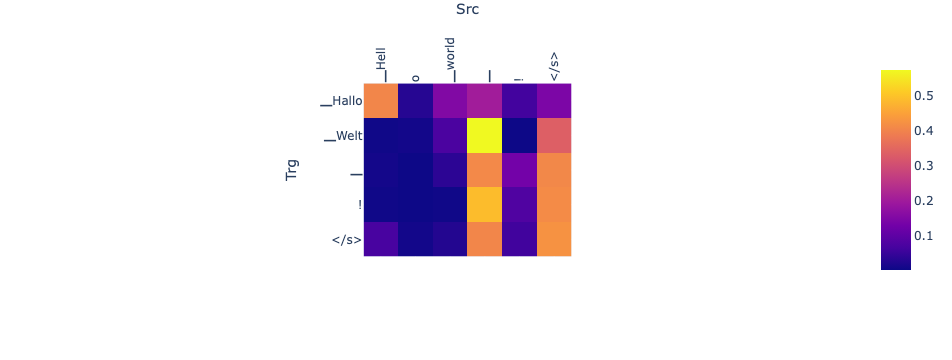

In [11]:
# get attention probs
ref_scores = de2en.score(
    src=['Hello world!'],
    trg=['Hallo Welt!'],
)

# plot
de2en.plot_attention(
    src='Hello world!',
    trg='Hallo Welt!',
    attention_scores=ref_scores[0].attention_probs[0],
)

## Prompting

JoeyNMT v2.3 supports multilingual translation with language tags.  
The following model is trained on iwslt14 en-de and en-fr sentence pairs with three language tags: `<de>`, `<en>` and `<fr>`.

In [ ]:
iwslt14 = torch.hub.load('joeynmt/joeynmt', 'iwslt14_prompt')

#### 1. language tags (multi-task learning)

In the src prompt, we tell the model from which language we are translating, and  
in the trg prompt, we tell the model to which language we are translating.

In [4]:
# de -> en
iwslt14.translate(
    src=["Hallo Welt!"],
    src_prompt=["<de>"],
    trg_prompt=["<en>"],
    beam_size=5,
    n_best=5,
)

['Hello world!', 'Hello world.', 'Hi World!', 'Hi world!', 'Hello, world!']

In [5]:
# en -> fr
iwslt14.translate(
    src=["How are you?"],
    src_prompt=["<en>"],
    trg_prompt=["<fr>"],
    beam_size=5,
    n_best=5,
)

['Comment es-tu ?',
 'Comment êtes-vous ?',
 'Comment êtes-vous?',
 'Comment allez-vous ?',
 'Comment vous êtes-vous ?']

In [6]:
# en -> de
iwslt14.translate(
    src=["How are you?"],
    src_prompt=["<en>"],
    trg_prompt=["<de>"],
    beam_size=5,
    n_best=5,
)

['Wie geht es Ihnen?',
 "Wie geht's dir?",
 "Wie geht's Ihnen?",
 'Wie sind Sie?',
 'Wie geht es dir?']

#### 2. trg context

In addition to the language tags, we can specify the context in the prompt.  
The model translated with "Sie", in a formal way, for the example above.  
We can tell the model that we'd like to translate it with "Du", in a more casual form.

In [7]:
iwslt14.translate(
    src=["How are you?"],
    src_prompt=["<en>"],
    trg_prompt=["<de> du"],
    beam_size=1,
)

['Wie bist du?']

#### 3. src context

In the following example, the model translated the English pronoun "it" into the neutral form "es" in all top-5 candidates.  
We can give src-side context, so that the model can get more hint about the gender of the pronoun.

In [8]:
# w/o src context
out = iwslt14.score(
    src=["I'll bring it."],
    src_prompt=["<en>"],
    trg_prompt=["<de>"],
    beam_size=5,
    n_best=5,
)
for n in range(5):
    print(f'{n+1} best: {out[0].sequence_probs[n]:.4f} | {out[0].translation[n]}')

1 best: -1.4792 | Ich werde es mitbringen.
2 best: -1.6045 | Ich bringe es dazu.
3 best: -1.6643 | Ich bringe es mit.
4 best: -1.6840 | Ich bringe es an.
5 best: -1.7278 | Ich bringe es.


In [9]:
# w/ src context
out = iwslt14.score(
    src=["I'll bring it."],
    src_prompt=["<en> There is a camera."],
    trg_prompt=["<de>"],
    beam_size=5,
    n_best=5,
)
for n in range(5):
    print(f'{n+1} best: {out[0].sequence_probs[n]:.4f} | {out[0].translation[n]}')

1 best: -1.6253 | Ich bringe es mit.
2 best: -1.6836 | Ich bringe es an.
3 best: -1.7318 | Ich werde es mitbringen.
4 best: -1.7923 | Ich bringe es.
5 best: -1.8206 | Ich bringe sie mit.


The feminine form "sie" appears at the 5th position of the nbest list,  
when we provide "camera" in the src prompt. (In German, "Kamera" is a feminine noun.)  
By designing the prompt, we can gain more control on the trg translation!

### Training with prompt

You can provide a tsv file containing all `src`, `src_prompt`, `trg`, and `trg_prompt`.
See `test/data/toy/dev.tsv` for example. In this case, we used a preceeding sentence as a prompt.

In [10]:
import pandas as pd

df = pd.read_csv("../test/data/toy/dev.tsv", sep="\t")
df[["src_prompt", "src", "trg_prompt", "trg"]].head(5)

src_prompt  \
0                                              <de>    
1            <de> Ich freue mich , dass ich da bin .   
2                              <de> Ja , guten Tag .   
3        <de> Ja , also , was soll Biohacking sein ?   
4  <de> Ich muss dazu erst mal ein bisschen ausho...   

                                                 src  \
0                 Ich freue mich , dass ich da bin .   
1                                   Ja , guten Tag .   
2             Ja , also , was soll Biohacking sein ?   
3  Ich muss dazu erst mal ein bisschen ausholen ,...   
4  Ich studiere Molekularbiologie und beschäftige...   

                                          trg_prompt  \
0                                               <en>   
1                        <en> I’m happy to be here .   
2                                 <en> Yes , hello .   
3               <en> Yes , so , what is biohacking ?   
4  <en> I’ll have to provide some background info...   

                                                 trg  
0                             I’m happy to be here .  
1                                      Yes , hello .  
2                    Yes , so , what is biohacking ?  
3  I’ll have to provide some background informati...  
4  I study molecular biology and have been doing ...

You also should pay attention to the `lang` section in the config.  
(We have multiple languages in both sides!)

```yaml
# config.yaml
...
data:
    train: "test/data/iwslt14/train"
    dev: "test/data/iwslt14/validation"
    test: "test/data/iwslt14/test"
    dataset_type: "tsv"
    src:
        lang: "src" # <- instead of "en", "de", etc.
        ...
        
    trg:
        lang: "trg" # <- instead of "en", "de", etc.
        ...
        
    special_symbols:
        unk_token: "<unk>"
        pad_token: "<pad>"
        bos_token: "<s>"
        eos_token: "</s>"
        sep_token: "<sep>" # <- sepatator token
        unk_id: 0
        pad_id: 1
        bos_id: 2
        eos_id: 3
        sep_id: 4 # <- separator token index
        lang_tags: ["<de>", "<en>"] # <- language tags
    ...
```

## Speech-to-Text

Load en ASR / en-de ST models trained on [MUST-C v2](https://mt.fbk.eu/must-c/) data.

:bulb: Note: This takes a few minutes.

In [ ]:
mustc_asr = torch.hub.load('may-/joeys2t', 'mustc_v2_en_asr')
mustc_st = torch.hub.load('may-/joeys2t', 'mustc_v2_ende_st')

Let's see how good / bad they work. (audio source: [librispeech](https://huggingface.co/datasets/librispeech_asr))

In [7]:
from pathlib import Path
import pandas as pd

hub_dir = Path(torch.hub.get_dir())
speech_dir = hub_dir / 'may-_joeys2t_main/test/data/speech/'

df = pd.read_csv(speech_dir / 'test.tsv', sep='\t')
inputs = [(speech_dir / s).as_posix() for s in df['src']]

Generate transcriptions / translations.

In [ ]:
beam_size = 1 # Greedy Decoding -> token-level log-likelihood
n_best = 1

asr_out = mustc_asr.score(inputs, beam_size=beam_size, n_best=n_best)
st_out = mustc_st.score(inputs, beam_size=beam_size, n_best=n_best)

Save outputs in a DataFrame.

In [9]:
df['asr_hyp'] = [out.translation[0] for out in asr_out]
df['asr_hyp_tokens'] = [out.tokens[0] for out in asr_out]
df['asr_hyp_scores'] = [out.token_probs[0].tolist() for out in asr_out]
df['st_hyp'] = [out.translation[0] for out in st_out]
df['st_hyp_tokens'] = [out.tokens[0] for out in st_out]
df['st_hyp_scores'] = [out.token_probs[0].tolist() for out in st_out]

Tokens with lower scores (= less confident) are marked in dark red.

In [10]:
from IPython.display import Audio, HTML, display
import numpy as np

def _format(hyp_tokens, hyp_scores):
    html = '<span style="margin-right: 3em;"></span>'
    for t, s in zip(hyp_tokens, hyp_scores):
        s = 1 - np.exp(s)
        html += f'<span style="background-color: rgba(255, 0, 0, {s}); margin-right: 5pt;">{t}</span>'
    html += '<br><br>'
    return html

def print_results(row):
    print(' Reference:', row['trg'].lower(), '\n')
    
    print('Hypothesis:', row['asr_hyp'], '\n')
    display(HTML(_format(row['asr_hyp_tokens'], row['asr_hyp_scores'])))
    
    print('Translation:', row['st_hyp'], '\n')
    display(HTML(_format(row['st_hyp_tokens'], row['st_hyp_scores'])))
    
    display(Audio((speech_dir / row['src']).as_posix()))
    print('\n', '-'*20, '\n')

for name, row in df.iterrows():
    print_results(row)

 Reference: and how odd the directions will look! 

Hypothesis: and how odd the directions will look 



Translation: Wie seltsam wird die Richtung aussehen? 




 -------------------- 

 Reference: poor alice! 

Hypothesis: <noise> <noise> <noise> <noise> <noise> <noise> <noise> 



Translation: <Geräusch>: "Armer Alice". 




 -------------------- 

 Reference: it was the white rabbit returning, splendidly dressed, with a pair of white kid gloves in one hand and a large fan in the other: he came trotting along in a great hurry, muttering to himself as he came, "oh the duchess, the duchess! 

Hypothesis: it was the white rabbit returny splendidly dressed with a pair of white kid gloves in one hand and a large fan in the other he came trotting along in a great hurry muttering to himself as he came oh the dutchest the dutches 



Translation: Er war der weiße Kaninchenbesser, der sich ausgesprochen mit der Papagei, weißer Kleider in der einen Hand und einem großen Fan im anderen, er ließ sich mit einem großen Hurriksch, der sich als König murmelte: "Oh, der Niederländer, der Niederländer. 




 -------------------- 

 Reference: oh! won't she be savage if i've kept her waiting!" 

Hypothesis: oh what should be savage if i've kept her waiting 



Translation: "Oh, was wäre, wenn ich sie aufs Warten gehalten hätte? 




 -------------------- 

 Reference: alice took up the fan and gloves, and, as the hall was very hot, she kept fanning herself all the time she went on talking: "dear, dear! how queer everything is to-day! 

Hypothesis: <noise> alexis kaplan and gloves and as the hall was very hot she kept fanning herself all the time she went on talking dear dear how queer everything is today 



Translation: <Geräusch> Alexander Perez: "Alles nahm die Fan und Kleidung, und als der Saal sehr heiß war, vergaß sie sich ständig". Sie ging immer weiter und sprach. "Lieb, trauer, wie queer alles ist, heute. 




 -------------------- 

 Reference: and yesterday things went on just as usual. 

Hypothesis: and yesterday things we're not just as usual 



Translation: Und gestern waren die Dinge nicht nur so gewöhnlich. 




 -------------------- 

 Reference: i wonder if i've been changed in the night? 

Hypothesis: i'm wonder if i've been changed in the night 



Translation: Ich frage mich, ob ich in der Nacht geändert wurde. 




 -------------------- 

 Reference: i almost think i can remember feeling a little different. 

Hypothesis: i almost think i can remember feeling a little different 



Translation: <Geräusch> NR: Ich denke fast, ich kann mich an etwas anderes erinnern. 




 -------------------- 

 Reference: i'll try if i know all the things i used to know. 

Hypothesis: i'll try if i know all the things i used to know 



Translation: Ich versuche, wenn ich all die Dinge kenne, die ich früher kannte. 




 -------------------- 

 Reference: i shall never get to twenty at that rate! 

Hypothesis: <noise> i shall never get to twenty at that rate 



Translation: <Geräusch> NR: Ich werde nie zu 20 auf diese Rechte gehen. 




 -------------------- 

